## 목적
- 위클리 주문수에 대한 수요예측
- 1) EDA
- 2) Modeling 
- 3) Evaluation

In [164]:
import logging
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import check_numeric
import shap
sns.set_style('darkgrid')
sns.set_palette("bright")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. EDA

In [159]:
file_path = "data"        
datasets = ['features', 'stores', 'train', 'test']
loaded_datasets = {}

def get_data():
    for data in datasets:
        df = pd.read_csv(f"{file_path}/{data}.csv") 
        df.columns = df.columns.str.lower()
        loaded_datasets[data] = df

    # 각각 df 불러오기
    features = loaded_datasets['features']
    stores = loaded_datasets['stores']
    train = loaded_datasets['train']
    df = train.merge(features, on=['store','date','isholiday'], how='left')\
              .merge(stores, on=['store'], how='left')
    
    # columns type change
    df['date'] = pd.to_datetime(df['date'])
    df['isholiday'] = df['isholiday'].astype(int)
    df['date_month'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m'))        
    return df

In [160]:
df = get_data()

In [161]:
print(df.shape)
print(df.store.nunique())
print(df.dept.nunique())

(421570, 17)
45
81


In [162]:
df.head()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size,date_month
0,1,1,2010-02-05,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010-02-01
1,1,1,2010-02-12,46039.49,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,2010-02-01
2,1,1,2010-02-19,41595.55,0,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,2010-02-01
3,1,1,2010-02-26,19403.54,0,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,2010-02-01
4,1,1,2010-03-05,21827.90,0,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,2010-03-01


In [163]:
# min minus?
df.weekly_sales.describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: weekly_sales, dtype: float64

In [98]:
df = df[df['weekly_sales'] >= 0]

In [86]:
# null check
df.isnull().sum()

store                0
dept                 0
date                 0
weekly_sales         0
isholiday            0
temperature          0
fuel_price           0
markdown1       270085
markdown2       309367
markdown3       283618
markdown4       285750
markdown5       269337
cpi                  0
unemployment         0
type                 0
size                 0
dtype: int64

In [99]:
fill_cols = ['markdown1','markdown2','markdown3','markdown4','markdown5']
df[fill_cols] = df[fill_cols].fillna(df[fill_cols].mean())

In [100]:
df.groupby(["type"])['weekly_sales'].mean().astype(int)

type
A    20145
B    12288
C     9547
Name: weekly_sales, dtype: int64

In [101]:
df.groupby(["date"]).size()

date
2010-02-05    2948
2010-02-12    2949
2010-02-19    2971
2010-02-26    2943
2010-03-05    2936
              ... 
2012-09-28    2952
2012-10-05    2967
2012-10-12    2979
2012-10-19    2947
2012-10-26    2951
Length: 143, dtype: int64

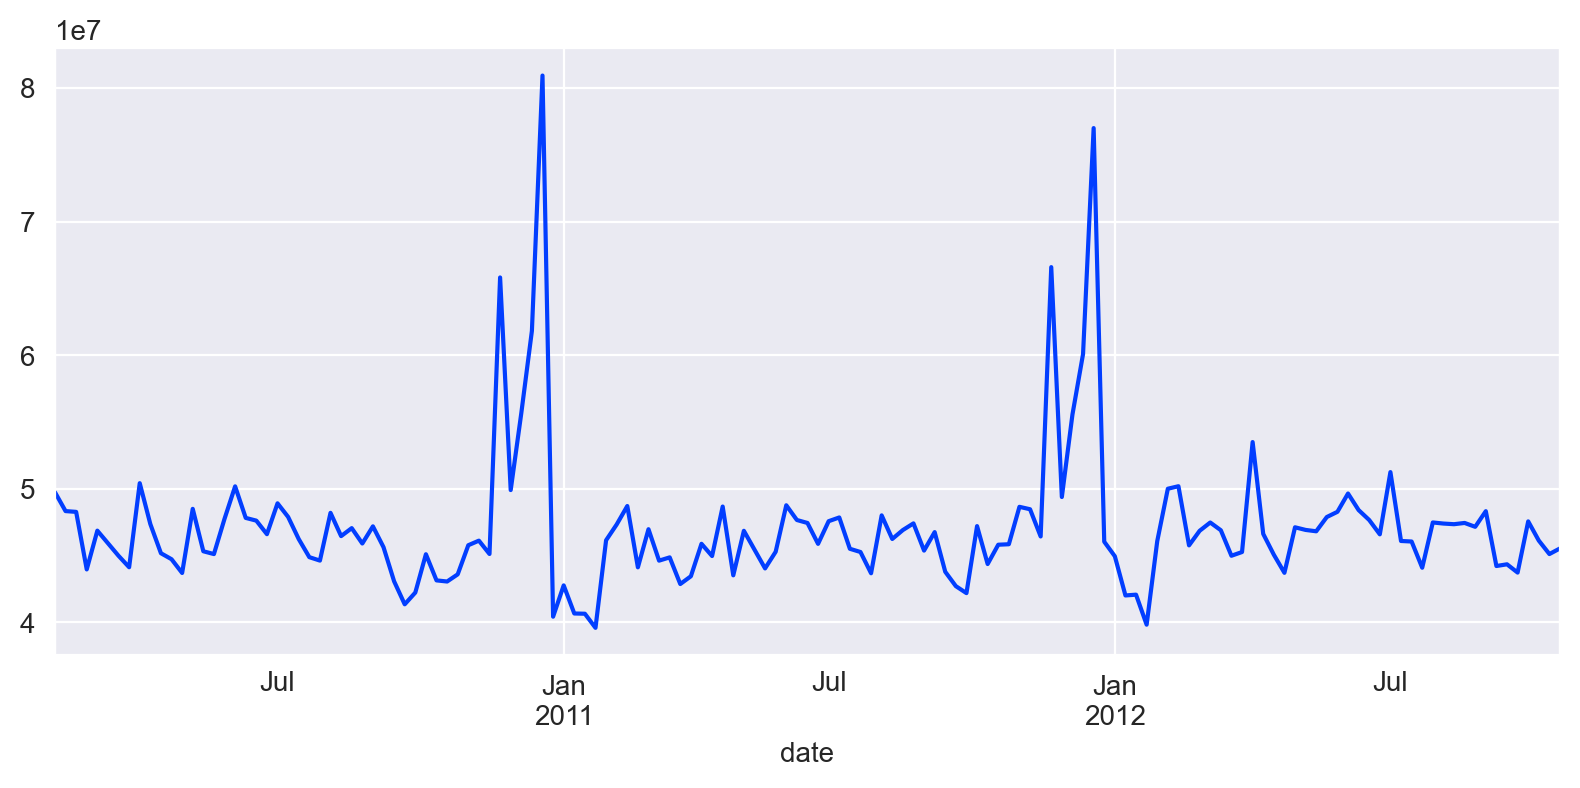

In [102]:
# black friday and 크리스마스에 peak
df.groupby(["date"]).weekly_sales.sum().plot(figsize=(8,4))
plt.tight_layout()

<Axes: xlabel='date_month'>

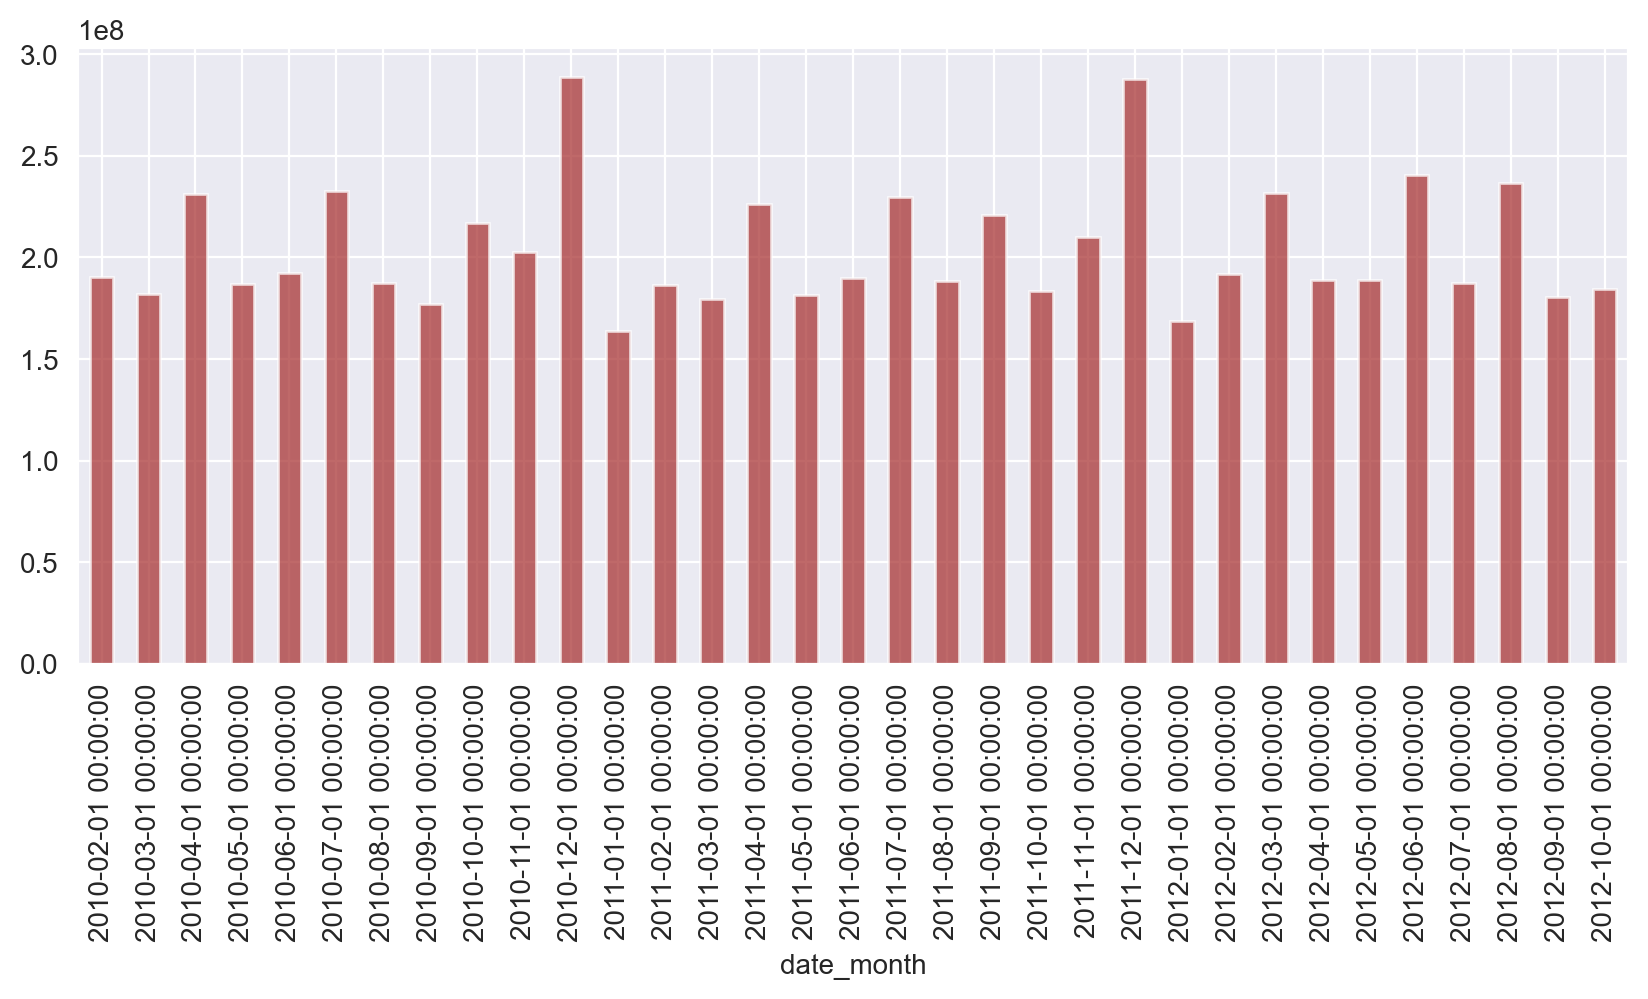

In [119]:
# 11,12,6월이 높은편
df.groupby("date_month")['weekly_sales'].sum().plot(kind='bar', alpha=.7, figsize=(10,4), color='brown')

In [59]:
df.head()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,7247.781936,3329.917771,1441.588079,3384.71861,4629.478027,211.350143,8.106,A,151315


In [103]:
# 공휴일에 높은 경향
df.groupby("isholiday")['weekly_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
isholiday,,,,,,,,
0,390722.0,15949.958317,22347.258698,0.0,2117.30,7636.08,20193.9125,406988.63
1,29563.0,17092.566220,27249.206776,0.0,2122.83,7997.86,21256.9150,693099.36


In [104]:
df.date.dt.day_name().value_counts() # Friday only

Friday    420285
Name: date, dtype: int64

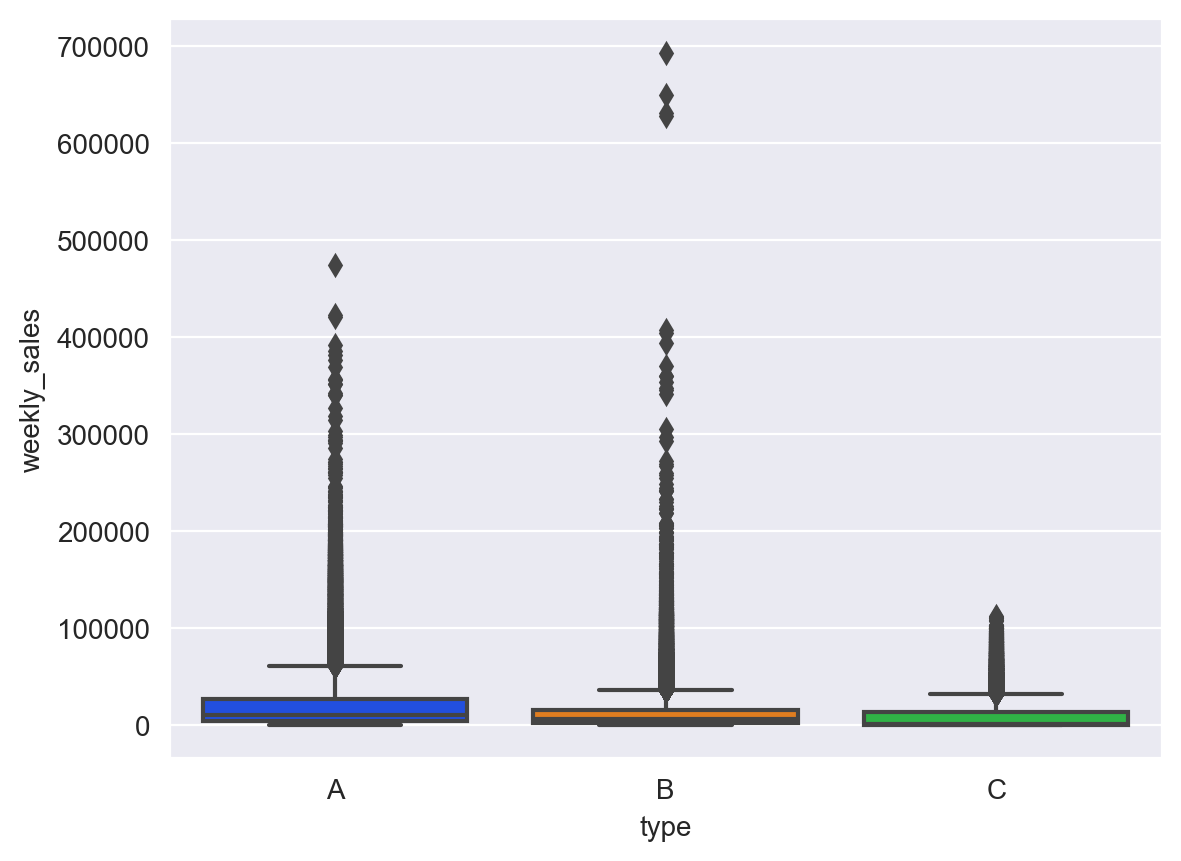

In [93]:
sns.boxplot(x="type", y="weekly_sales", data=df)
plt.show()

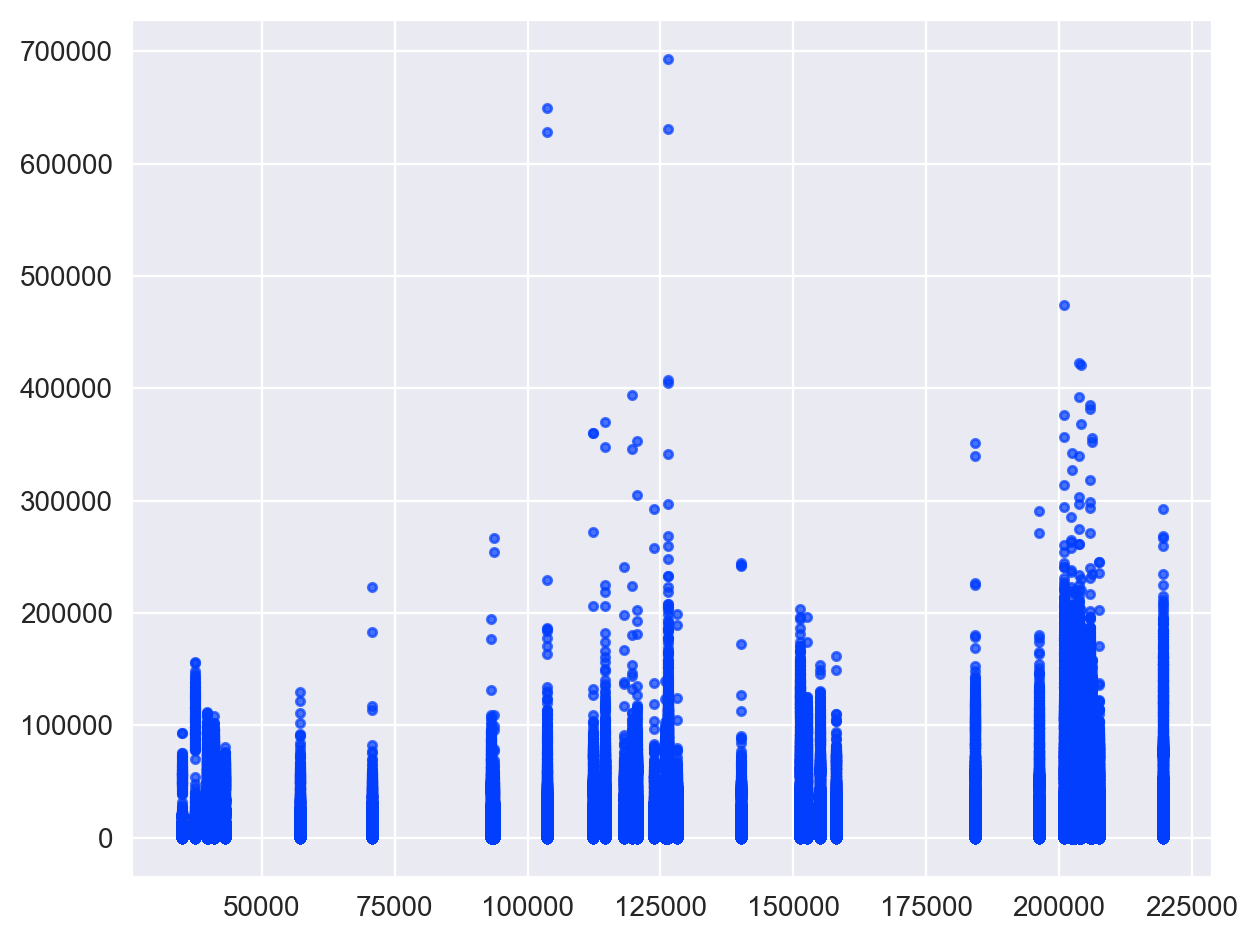

In [94]:
# 사이즈에 따라 주문수가 조금은 높아지는 경향
plt.scatter(df['size'], df['weekly_sales'], s=9, alpha=.7)
plt.tight_layout()

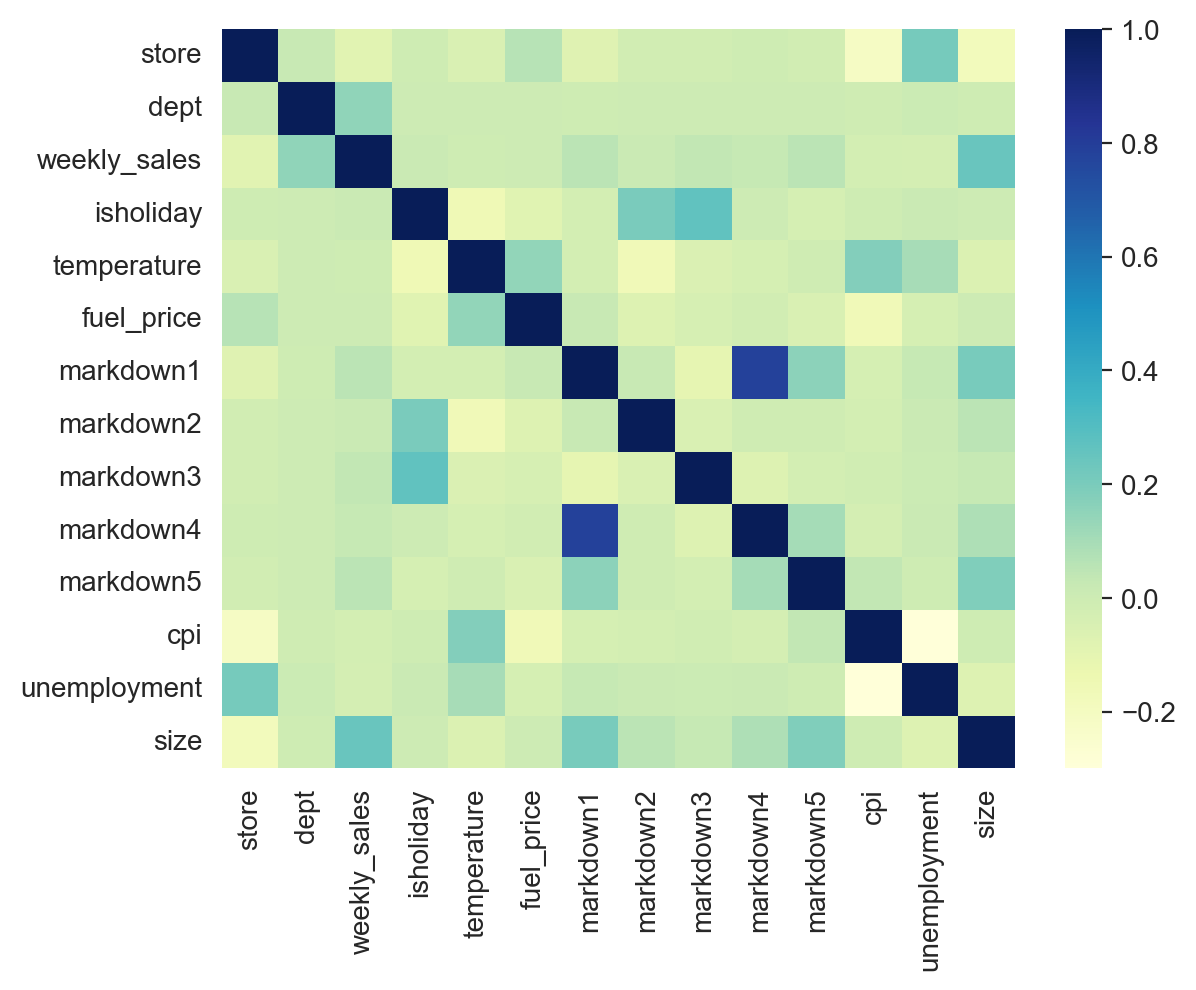

In [125]:
# weak correlation with dept, size 
sns.heatmap(df.corr(), cmap='YlGnBu')
plt.show()

## 2. Modeling 

In [165]:
class SalesPredict:

    """
    store 별 판매량 예측
     > trainset: 2010-02-05 ~ 2012-10-26
     > testset: 2012-11-02 ~ 2013-07-26
    """    
    def __init__(self, algo_type):
        self.file_path = "data"        
        self.datasets = ['features', 'stores', 'train', 'test']
        self.test_start_date = '2012-10-01'
        self.loaded_datasets = {}
        self.label_encoder = LabelEncoder()
        self.target_encoder = ce.TargetEncoder(cols=['store'])        
        self.base_model = LGBMRegressor(random_state=42)
        self.algo_type =  algo_type
        self.opt_param = False # True 경우 파라메터 최적화 진행
        self.param_dist = {
            'regressor__n_estimators': np.arange(50, 500, 50),
            'regressor__learning_rate': [0.01, 0.1, 0.2, 0.3],
            'regressor__max_depth': np.arange(3, 10),
            'regressor__subsample': np.arange(0.5, 1.0, 0.1),
            'regressor__colsample_bytree': np.arange(0.5, 1.0, 0.1)
        }    
        
    def load_data(self):
        """
        데이터셋 불러오기
        분리된 데이터셋을 병합
        """
        for data in self.datasets:
            df = pd.read_csv(f"{self.file_path}/{data}.csv") 
            df.columns = df.columns.str.lower()
            self.loaded_datasets[data] = df
        
        # 각각 df 불러오기
        features = self.loaded_datasets['features']
        stores = self.loaded_datasets['stores']
        train = self.loaded_datasets['train'] 
        #test = self.loaded_datasets['test'] # 정답값이 없음
                
        # 병합
        df = train.merge(features, on=['store','date','isholiday'], how='left')\
                  .merge(stores, on=['store'], how='left')
        
        # columns type change
        df['date'] = pd.to_datetime(df['date'])
        df['isholiday'] = df['isholiday'].astype(int)
        
        # shape check
        assert len(df) == len(train)
        df = df[df['weekly_sales']>=0]
        print("total_df_shape:", df.shape)
        return df
    
    
    def add_date_features(self, df):        
        """
        날짜 관련 피처엔지니어링
        """
        df['month'] = df['date'].dt.month
        #df['day'] = df['date'].dt.dayofweek
        #df['dayofweek'] = df['date'].dt.day_name()
        #df["weekend_yn"] = np.where(df["dayofweek"].isin(["Saturday", "Sunday"]), 1, 0)  # 주말여부
        df["dayofyear"] = df['date'].dt.dayofyear  # 연간 일                
        df["week_no"] = df['date'].dt.isocalendar()['week'].astype('int')
        df['week_num'] = np.ceil((df['date'].dt.to_period('M').dt.to_timestamp().dt.weekday + df['date'].dt.day) / 7.0).astype(int)  # 월별주차
        #df = pd.concat([df, pd.get_dummies(data=df['dayofweek'], prefix='dayofweek')], axis=1)  # 요일 one-hot encoding

        # 월별 누적주문수
        # monthly prediction을 위해 YYYY-MM 형태로 변환
        df['date_month'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m'))        
        df['salse_cnt_cum'] = df.groupby(['date_month', 'store', 'dept'])['weekly_sales'].cumsum()        
        return df
    
    
    def add_fe_laggging(self, df, max_lagging_n=14):
        """
        lagging 피처 및 rolling mean 피처 추가
        """
        # 이전 주문수 피처
        for n in np.arange(2, max_lagging_n):
            df[f'ord_cnt_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].shift(n)
            df[f'ord_cnt_cum_d{n}'] = df.groupby(['store', 'dept'])['salse_cnt_cum'].shift(n)
            
        # for n in np.arange(1, max_lagging_n):
        #     df[f'ord_cnt_roll_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].transform(lambda x: x.rolling(n,1).mean())
        #     df[f'ord_cnt_ewm_d{n}'] = df.groupby(['store', 'dept'])['weekly_sales'].transform(lambda x: x.ewm(span=n, adjust=False).mean())
        return df
    
  
    def add_fe_change_ratio(self, df):
        
        """
        주문수 변동율을 피처로 활용
        """
        #df[f'ord_cnt_change_d1'] = (df[f'ord_cnt_d1']-df[f'ord_cnt_d2'])/df[f'ord_cnt_d2']
        df[f'ord_cnt_change_d2'] = (df[f'ord_cnt_d2']-df[f'ord_cnt_d3'])/df[f'ord_cnt_d3']    
        df[f'ord_cnt_change_d4'] = (df[f'ord_cnt_d4']-df[f'ord_cnt_d5'])/df[f'ord_cnt_d6']        
        # 누적기준
        #df[f'ord_cnt_change_d1'] = (df[f'ord_cnt_cum_d1']-df[f'ord_cnt_cum_d2'])/df[f'ord_cnt_cum_d2']
        df[f'ord_cnt_change_d2'] = (df[f'ord_cnt_cum_d2']-df[f'ord_cnt_cum_d3'])/df[f'ord_cnt_cum_d3']        
        df[f'ord_cnt_change_d4'] = (df[f'ord_cnt_cum_d4']-df[f'ord_cnt_cum_d5'])/df[f'ord_cnt_cum_d6']
        
        return df
    
    
    def _split_data(self, df):        
        """
        특정날짜 기준으로 데이터셋 분리(학습용, 검증용)
        """
        # index를 date로 지정
        if 'date' in df.columns:
            df = df.set_index("date")             
        fill_cols = ['markdown1','markdown2','markdown3','markdown4','markdown5']
        df[fill_cols] = df[fill_cols].fillna(df[fill_cols].mean())
        df = df.dropna()
            
        # 컬럼제거: leakage 방지
        drop_cols = ['weekly_sales', 'date_month', 'salse_cnt_cum']        
        
        # 최신값까지 누적하여 하나의 날짜에 대해 예측하고 append
        train = df[df.index < self.test_start_date]
        pred = df[df.index >= self.test_start_date]
        print("test_fist_date:", self.test_start_date)
        
        # 학습용 데이터셋
        train['type'] = self.label_encoder.fit_transform(train['type'])
        train['store_enc'] = self.target_encoder.fit_transform(train['store'], train['weekly_sales'])
        X_train = train.drop(drop_cols, axis=1)
        y_train = train[['weekly_sales']]

        # 성능 검증용 데이터셋
        pred['type'] = self.label_encoder.transform(pred['type'])
        pred['store_enc'] = self.target_encoder.transform(pred['store'], pred['weekly_sales'])
        X_pred = pred.drop(drop_cols, axis=1)
        y_pred = pred[['weekly_sales', 'store', 'dept']]  
        
        return X_train, y_train, X_pred, y_pred
        
    
    def fit_predict(self, df):
        """
        데이터셋 분리후 학습, CV, 검증
        """          
        X_train, y_train, X_pred, y_pred = self._split_data(df)                    
        
        if self.algo_type == 'vote_regressor':                              
            lgb_model = self.base_model                                                        
            rf_model = RandomForestRegressor(random_state=42)                        
            vote_model = VotingRegressor([('base', lgb_model), ('rf', rf_model)])                     
            vote_model.fit(X_train, y_train)
            y_pred['pred_cnt'] = vote_model.predict(X_pred).astype(int)
            pred_res = y_pred.copy()   
        
        elif self.algo_type == 'pipeline_cv':            
            pipeline = Pipeline([
                ('scaler', StandardScaler()),                   
                ('feature_selection', SelectKBest(f_regression, k=15)),
                ('regressor', LGBMRegressor())                 
                ])            
            random_search = RandomizedSearchCV(pipeline, param_distributions=self.param_dist, n_iter=10, cv=5, scoring='r2', random_state=42)
            random_search.fit(X_train, y_train)
            print("Best hyperparameters:", random_search.best_params_)
            print("Best R-squared score:", random_search.best_score_)
            best_model = random_search.best_estimator_
            y_pred['pred_cnt'] = best_model.predict(X_pred).astype(int)                         
            pred_res = y_pred.copy()   
        else:
            lgb_model = self.base_model
            lgb_model.fit(X_train, y_train)
            y_pred['pred_cnt'] = lgb_model.predict(X_pred).astype(int)
            pred_res = y_pred.copy()               
        
        # MdAPE
        pred_res['ape'] = 1-(abs(pred_res['weekly_sales']-pred_res['pred_cnt'])/pred_res['weekly_sales'])
        pred_res['gap'] = pred_res['pred_cnt']-pred_res['weekly_sales']
        print("train_shape:", X_train.shape)
        print("test_shape:", X_pred.shape)
        print("MdAPE", pred_res.ape.median())
        print("R2_score", r2_score(pred_res['weekly_sales'], pred_res['pred_cnt']))
        return df, pred_res        
    
    
    def process(self):
        
        df = self.load_data()
        df = self.add_date_features(df)
        df = self.add_fe_laggging(df)
        #df = self.add_fe_change_ratio(df)        
        df, pred_res = self.fit_predict(df)
        
        return pred_res

In [145]:
# algo_type = ['pipeline_cv', 'vote_regressor', 'base']

In [166]:
# base model
base_predictor = SalesPredict('base')
base_pred_res = base_predictor.process()

total_df_shape: (420285, 16)
test_fist_date: 2012-10-01
train_shape: (366946, 43)
test_shape: (11809, 43)
MdAPE 0.8906623186888254
R2_score 0.9842551075464101


In [ ]:
# param opt model
pipe_predictor = SalesPredict('pipeline_cv')
pipe_pred_res = pipeline_predictor.process()

In [ ]:
# voting model
vote_predictor = SalesPredict('vote_regressor')
vote_pred_res = vote_predictor.process()

In [167]:
pred_res.head()

,weekly_sales,store,dept,pred_cnt,ape,gap
date,,,,,,
2012-10-05,21904.47,1,1,23528,0.925881,1623.53
2012-10-12,22764.01,1,1,21289,0.935204,-1475.01
2012-10-19,24185.27,1,1,22658,0.936851,-1527.27
2012-10-26,27390.81,1,1,26702,0.974853,-688.81
2012-10-05,48577.08,1,2,46701,0.961379,-1876.08


In [190]:
# voting model
#self = SalesPredict('vote_regressor')
#df, pred_res = self.process()

## 3. Evaluation

In [168]:
pred_res

,weekly_sales,store,dept,pred_cnt,ape,gap
date,,,,,,
2012-10-05,21904.47,1,1,23528,0.925881,1623.53
2012-10-12,22764.01,1,1,21289,0.935204,-1475.01
2012-10-19,24185.27,1,1,22658,0.936851,-1527.27
2012-10-26,27390.81,1,1,26702,0.974853,-688.81
2012-10-05,48577.08,1,2,46701,0.961379,-1876.08
...,...,...,...,...,...,...
2012-10-26,6817.48,45,97,6631,0.972647,-186.48
2012-10-05,628.10,45,98,410,0.652762,-218.10
2012-10-12,1061.02,45,98,463,0.436373,-598.02


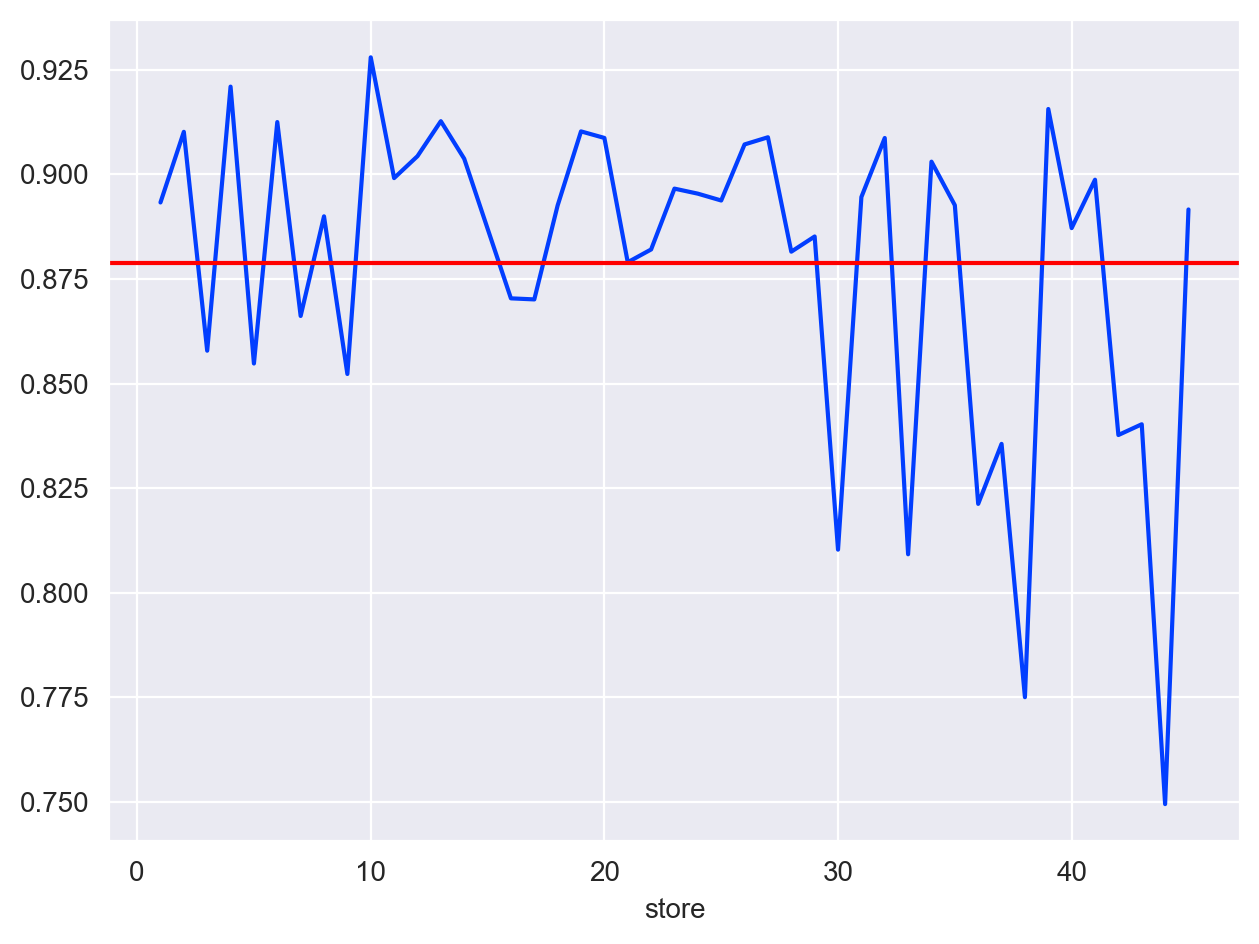

In [169]:
pred_res.groupby('store').ape.median().plot()
plt.axhline(y = pred_res.groupby('store').ape.median().mean(), color='r', linestyle='-')
plt.tight_layout()

In [172]:
pred_res.groupby('store').ape.median().sort_values().head(5)

store
44    0.749527
38    0.775076
33    0.809222
30    0.810325
36    0.821257
Name: ape, dtype: float64

<Axes: >

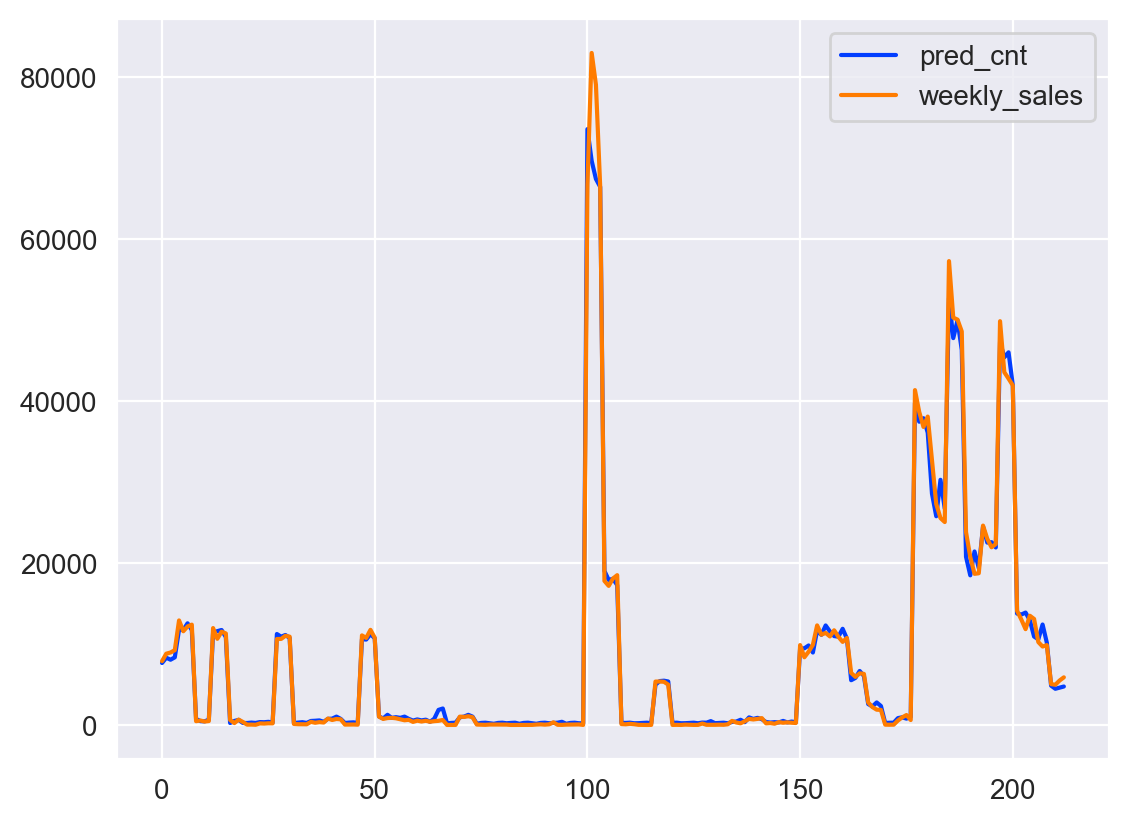

In [179]:
pred_res.query("store == 38").reset_index()[['pred_cnt', 'weekly_sales']].plot()
#plt.tight_layout()

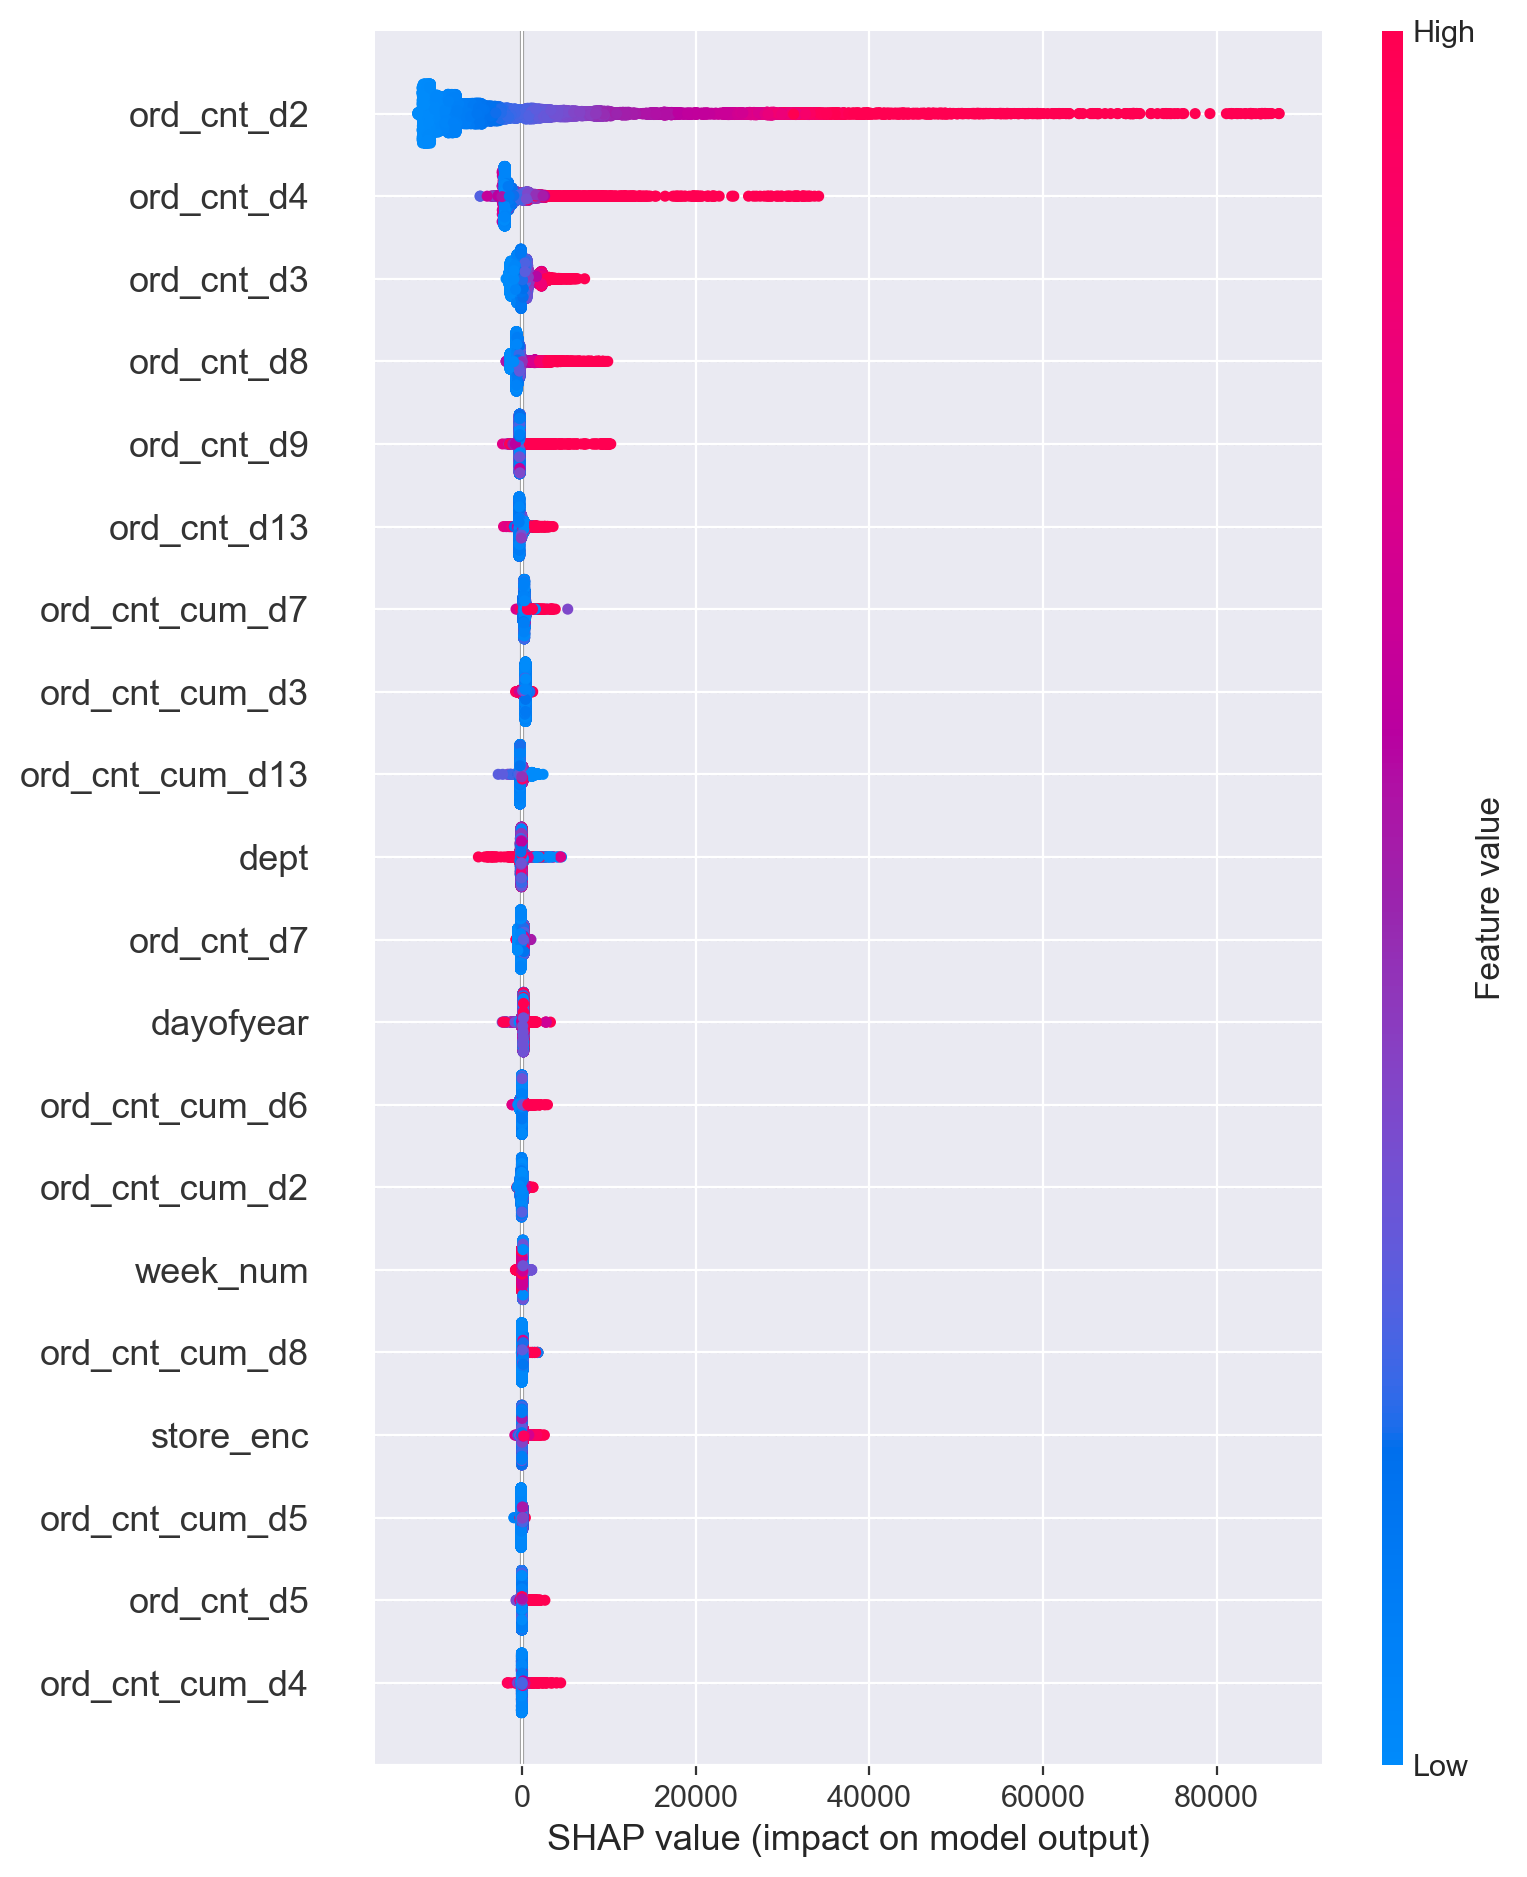

In [180]:
def _check_feature_importance(df):        
    """
    shap value 확인
    """        
    # index를 date로 지정
    if 'date' in df.columns:
        df = df.set_index("date")             
    fill_cols = ['markdown1','markdown2','markdown3','markdown4','markdown5']
    df[fill_cols] = df[fill_cols].fillna(df[fill_cols].mean())
    df = df.dropna()

    # 컬럼제거: leakage 방지
    drop_cols = ['weekly_sales', 'date_month', 'salse_cnt_cum']        

    # shap value check
    train = df[df.index < self.test_start_date]
    pred = df[df.index >= self.test_start_date]

    train['type'] = self.label_encoder.fit_transform(train['type'])
    train['store_enc'] = self.target_encoder.fit_transform(train['store'], train['weekly_sales'])
    X_train = train.drop(drop_cols, axis=1)
    y_train = train[['weekly_sales']]

    # 성능 체크 용도
    pred['type'] = self.label_encoder.transform(pred['type'])
    pred['store_enc'] = self.target_encoder.transform(pred['store'], pred['weekly_sales'])
    X_pred = pred.drop(drop_cols, axis=1)
    y_pred = pred[['weekly_sales', 'store', 'dept']] 

    model = self.base_model
    model.fit(X_train, y_train)
    y_pred['pred_cnt'] = model.predict(X_pred).astype(int)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_pred)        
    shap.summary_plot(shap_values, X_pred)
    
    
_check_feature_importance(df)    

In [181]:
pred_res.groupby("store").ape.median().sort_values(ascending=False).head(20)#.plot(kind='bar')

store
10    0.927953
4     0.920957
39    0.915608
13    0.912700
6     0.912490
19    0.910258
2     0.910151
27    0.908856
20    0.908696
32    0.908676
26    0.907143
12    0.904339
14    0.903736
34    0.903028
11    0.899103
41    0.898715
23    0.896584
24    0.895381
31    0.894570
25    0.893748
Name: ape, dtype: float64

In [182]:
pred_res['gap'] = pred_res['pred_cnt']-pred_res['weekly_sales']

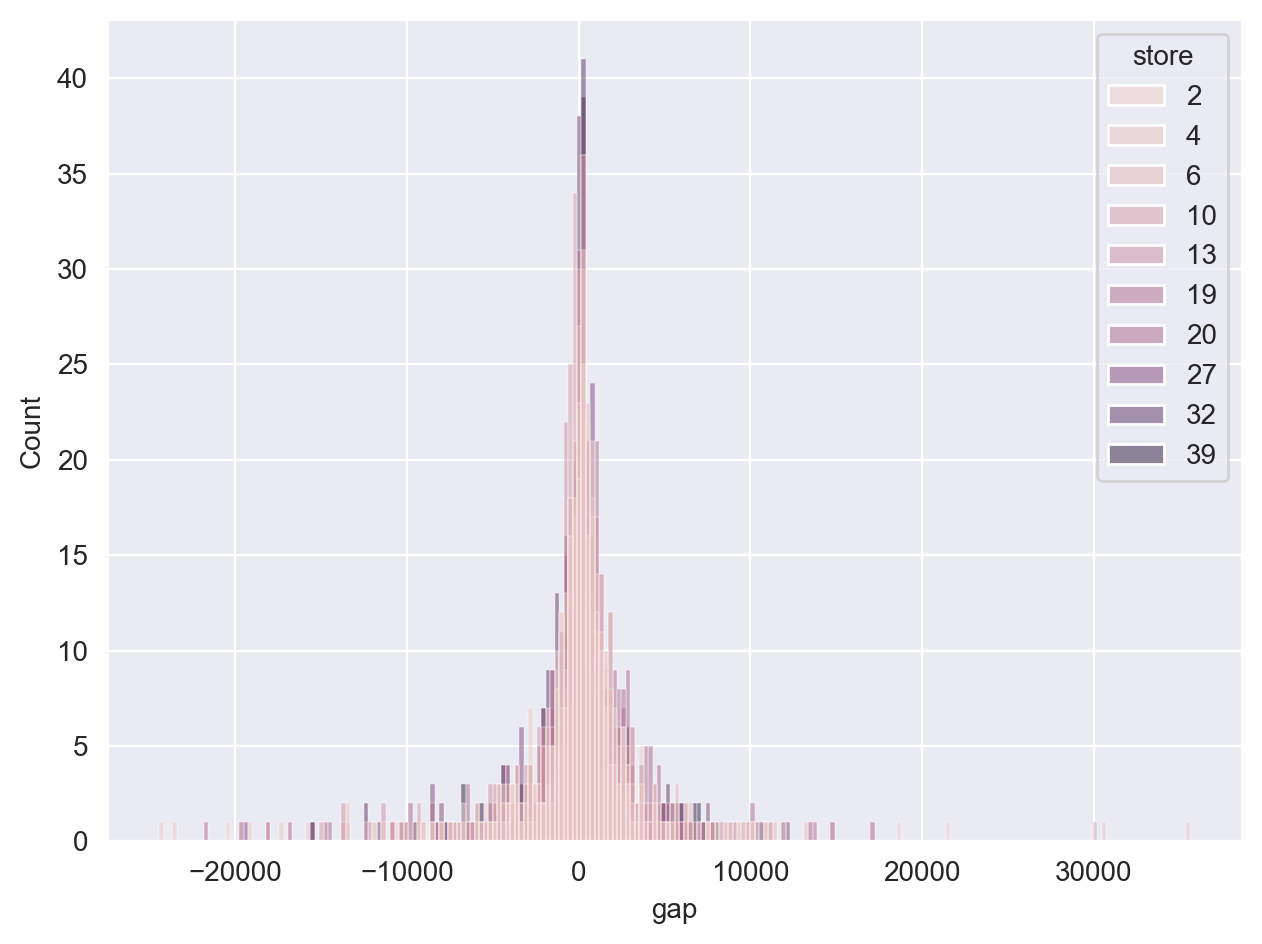

In [188]:
# 정확도 상위 5
store_list = pred_res.groupby("store").ape.median().sort_values(ascending=False).head(10).index

sns.histplot(x="gap", hue="store", data=pred_res[pred_res['store'].isin(store_list)])
plt.tight_layout()

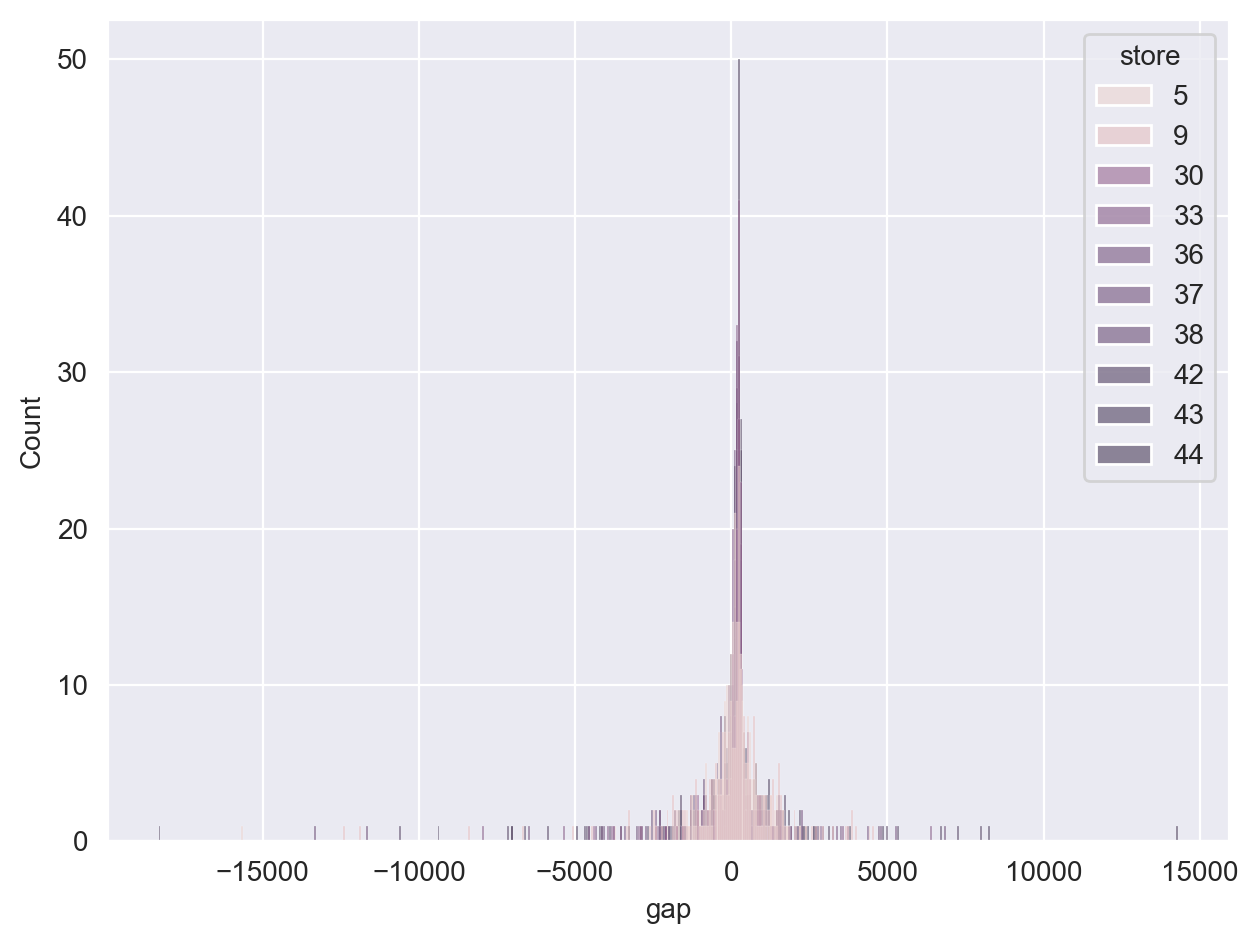

In [186]:
# 하위 5
low_store_list = pred_res.groupby("store").ape.median().sort_values(ascending=False).tail(10).index

sns.histplot(x="gap", hue="store", data=pred_res[pred_res['store'].isin(low_store_list)])
plt.tight_layout()